c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
train Loss: 0.0969 Acc: 0.9811
val Loss: 0.0076 Acc: 0.9998
Epoch 2/10
train Loss: 0.0152 Acc: 0.9986
val Loss: 0.0024 Acc: 0.9995
Epoch 3/10
train Loss: 0.0086 Acc: 0.9986
val Loss: 0.0012 Acc: 1.0000
Epoch 4/10
train Loss: 0.0074 Acc: 0.9985
val Loss: 0.0009 Acc: 1.0000
Epoch 5/10
train Loss: 0.0037 Acc: 0.9995
val Loss: 0.0004 Acc: 1.0000
Epoch 6/10
train Loss: 0.0028 Acc: 0.9996
val Loss: 0.0003 Acc: 1.0000
Epoch 7/10
train Loss: 0.0052 Acc: 0.9985
val Loss: 0.0006 Acc: 0.9998
Epoch 8/10
train Loss: 0.0028 Acc: 0.9992
val Loss: 0.0002 Acc: 1.0000
Epoch 9/10
train Loss: 0.0019 Acc: 0.9996
val Loss: 0.0003 Acc: 1.0000
Epoch 10/10
train Loss: 0.0013 Acc: 0.9997
val Loss: 0.0001 Acc: 1.0000


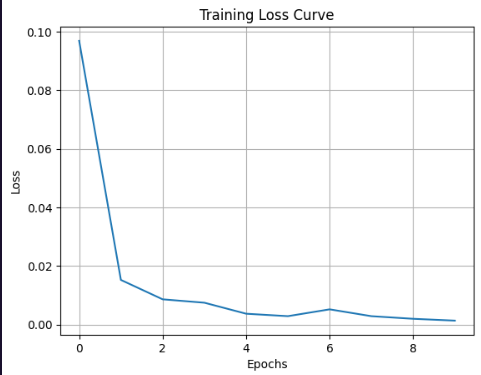

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import copy
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths (replace with your actual path)
data_dir = './medical_mnist_dataset'  # Should contain 'train', 'val' folders with class subfolders

# Transforms
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Load dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Load pretrained model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Training function
def train_model(model, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, train_loss_history

# Train the model
trained_model, loss_curve = train_model(model, criterion, optimizer, num_epochs=10)

# Plot Loss Curve
plt.plot(loss_curve)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
